In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np
import scipy.linalg

The goal here is to simulate the ladder filter from http://hasler.ece.gatech.edu/LinearPhaseFilterLadderFilterFeb2021.pdf

This has a single input ($V_{in}$) and multiple output taps ($V_1, V_2, V_3, ... V_m$).  The equations are:

$\tau{{dV_1} \over {dt}} = V_{in} -aV_1 - V_2$

$\tau{{dV_2} \over {dt}} = V_1 -aV_2 - V_3$

$\tau{{dV_3} \over {dt}} = V_2 -aV_3 - V_4$

$...$

$\tau{{dV_{m-1}} \over {dt}} = V_{m-2} -aV_{m-1} - V_m$

$\tau{{dV_{m}} \over {dt}} = V_{m-1} - V_m$  (note: is this right?  Or does this need the $a$ term as well?  I don't think so, as that'd interfere with the termination boundary condition)


where:
 - $m$ is the number of taps
 - $a$ is the attenuation due to the finite gain of the amplifiers ($a = 1/(G_m R_o)$)
 - $\tau$ is the time constant ($C_2/G_{m1}$ for the odd taps, and $C_1/G_{m2}$ for the even taps).

Note: the formulation I've given here isn't explicitly given in the paper, as the paper tends to use the second-order equations.  But, you can confirm that it matches with equations 8 and 9 (when $a=0$) by substitution.  And it also matches the equation given just before equation 16 in the text.  So, I think I'm correct in this formulation, but please point out anything I've done wrong!


This is a nice standard linear system, so let's go ahead an implement it using a standard $\dot x = Ax + Bu$ setup.

We'll start with a standard forward Euler implementation (we'll switch to ZOH below).  I'm using the `nengo.Process` framework to define this, but I'll note that that's just giving a basic structure for implementation -- it's not changing the math or computation in any way from what is defined here.

In [142]:
class LadderEuler(nengo.Process):
    def __init__(self, tau, m, a, size_in=1):
        self.m = m              # number of taps
        self.a = a              # attenuation constant
        self.tau = tau          # time constant
        self.size_in = size_in  # number of input channels

        # generate the matrices
        A = np.zeros((m, m))
        B = np.zeros((m, 1))
        for i in range(m-1):
            A[(i, i)] = -a
            A[(i, i+1)] = -1
            A[(i+1, i)] = 1
        A[(m-1, m-1)] = -1
        B[0] = 1
            
        self.A = A / tau
        self.B = B / tau        
        
        super().__init__(default_size_in=size_in, default_size_out=m*size_in)

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        state = np.zeros((self.m, self.size_in))

        # this code will be called every timestep
        def step_ladder(t, x, state=state):
            state[:] += dt*(np.dot(self.A, state) + np.dot(self.B, x[None, :]))
            return state.T.flatten()
        return step_ladder

Let's take a look at that matrix to see if it's defined correctly

In [143]:
print('No attenuation')
ladder = LadderEuler(tau=1.0, m=6, a=0)
print(ladder.A)

print('With attenuation')
ladder = LadderEuler(tau=1.0, m=6, a=0.1)
print(ladder.A)

No attenuation
[[ 0. -1.  0.  0.  0.  0.]
 [ 1.  0. -1.  0.  0.  0.]
 [ 0.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.]
 [ 0.  0.  0.  1.  0. -1.]
 [ 0.  0.  0.  0.  1. -1.]]
With attenuation
[[-0.1 -1.   0.   0.   0.   0. ]
 [ 1.  -0.1 -1.   0.   0.   0. ]
 [ 0.   1.  -0.1 -1.   0.   0. ]
 [ 0.   0.   1.  -0.1 -1.   0. ]
 [ 0.   0.   0.   1.  -0.1 -1. ]
 [ 0.   0.   0.   0.   1.  -1. ]]


Okay, now let's try using this to replicate Figure 3 in the paper.

We start by generating our input signal.  This is a 5kHz sine wave over 1ms.  We'll use a very small dt since we're just doing forward Euler at the moment.

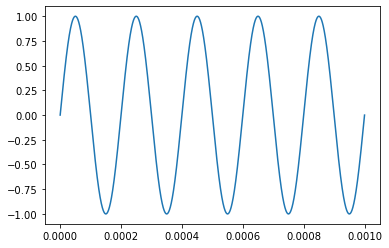

In [159]:
dt = 1e-9
T = 0.001
freq = 5000

t = np.arange(int(T/dt))*dt
signal = np.sin(t*2*np.pi*freq).reshape(-1, 1)

plt.plot(t, signal)
plt.show()

Now let's feed that input signal into our ladder.  The plot has $m=10$ and a tap delay of 4.2$\mu$s, and per equation 15 the delay is $\tau/2$, so we want $\tau$=8.4$\mu$s.  The attenuation shown in Fig 3c is mild, so let's try $a=0.2$.

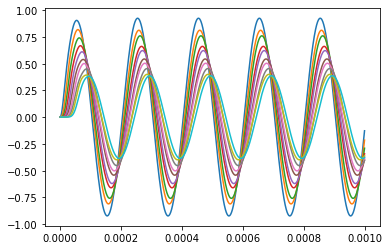

In [160]:
ladder = LadderEuler(tau=8.4e-6, m=10, a=0.2)
output = ladder.apply(signal, dt=dt)
plt.plot(t, output)
plt.show()

That looks pretty good!  Let's try making the plot look like the one in the paper.

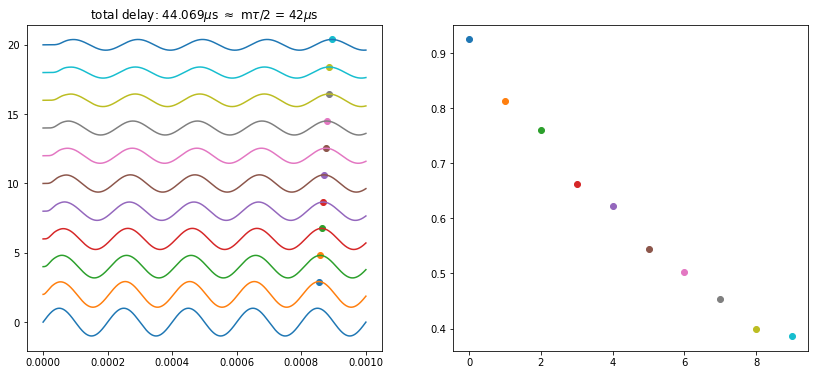

In [161]:
def make_delay_plot(ladder, signal, output):
    plt.figure(figsize=(14,6))
    plt.subplot(1, 2, 1)

    plt.plot(t, signal)
    for i in range(ladder.m):
        plt.plot(t, output[:,i]+(i+1)*2)
    peaks = np.argmax(output[-int(1/(dt*freq)):], axis=0)
    start_peak = np.argmax(signal[-int(1/(dt*freq)):], axis=0)
    total_delay = (peaks[-1] - start_peak[0])*dt
    for i in range(ladder.m):
        index = -int(1/(dt*freq)) + peaks[i]
        plt.scatter([t[index]], [output[index,i]+(i+1)*2])
    plt.title(f'total delay: {total_delay*1e6:g}$\mu$s $\\approx$ m$\\tau$/2 = {ladder.m*ladder.tau/2*1e6:g}$\mu$s')

    plt.subplot(1, 2, 2)
    for i in range(ladder.m):
        index = -int(1/(dt*freq)) + peaks[i]
        plt.scatter([i], [output[index,i]])

    plt.show()
make_delay_plot(ladder, signal, output)

That looks good, although there seems to be some strange synchronizing going on between some pairs.  This seems to be more prominent with less attenuation.  Here I try with $a=0.1$

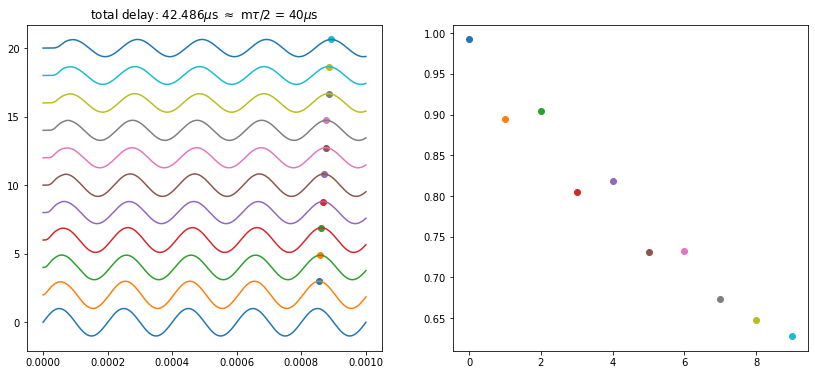

In [162]:
ladder = LadderEuler(tau=8e-6, m=10, a=0.1)
output = ladder.apply(signal, dt=dt)
make_delay_plot(ladder, signal, output)

I'm not sure what's causing that.  So as a next step, let's improve our simulation method by implementing a zero-order-hold version, since this is all linear.

In [163]:
class LadderZOH(nengo.Process):
    def __init__(self, tau, m, a, size_in=1):
        self.m = m              # number of taps
        self.a = a              # attenuation constant
        self.tau = tau          # time constant
        self.size_in = size_in  # number of input channels

        # generate the matrices
        A = np.zeros((m, m))
        B = np.zeros((m, 1))
        for i in range(m-1):
            A[(i, i)] = -a
            A[(i, i+1)] = -1
            A[(i+1, i)] = 1
        A[(m-1, m-1)] = -1
        B[0] = 1
            
        self.A = A / tau
        self.B = B / tau        
        
        super().__init__(default_size_in=size_in, default_size_out=m*size_in)

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        state = np.zeros((self.m, self.size_in))
        Ad = scipy.linalg.expm(self.A*dt)
        Bd = np.dot(np.dot(np.linalg.inv(self.A), (Ad-np.eye(self.m))), self.B)
        # this code will be called every timestep
        def step_ladder(t, x, state=state):
            state[:] = np.dot(Ad, state) + np.dot(Bd, x[None, :])
            return state.T.flatten()
        return step_ladder

First we'll try the $a=0.2$ version:

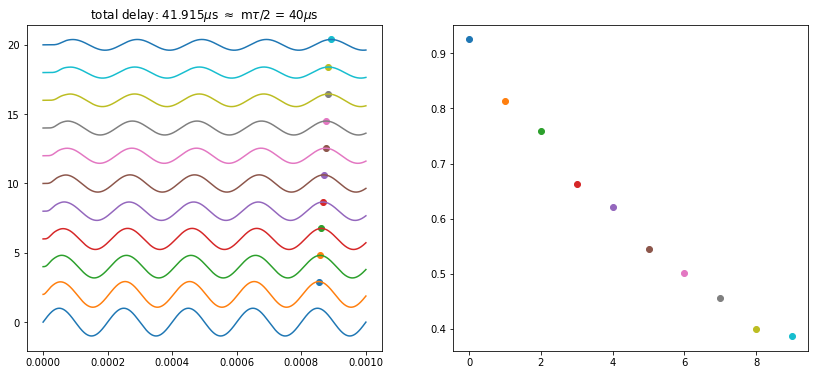

In [165]:
ladder = LadderZOH(tau=8e-6, m=10, a=0.2)
output = ladder.apply(signal, dt=dt)
make_delay_plot(ladder, signal, output)

That looks pretty identical to the Euler version.  

Here's the $a=0.1$

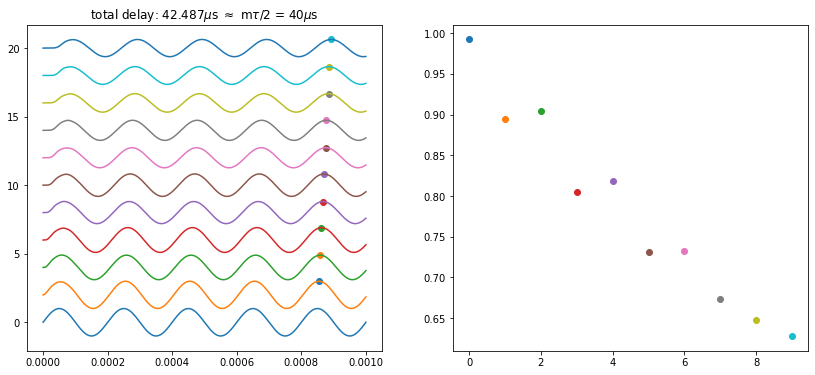

In [164]:
ladder = LadderZOH(tau=8e-6, m=10, a=0.1)
output = ladder.apply(signal, dt=dt)
make_delay_plot(ladder, signal, output)

The same synchronization seems to be happening.  Is this a real effect in the physical system?  Any ideas about what could be changed to avoid this in simulation if it isn't?

In the meantime, though, we can check if the ZOH version handles larger dt than the Euler version, as it should.  The simulations above were using dt=1ns, so let's try dt=1$\mu$s.

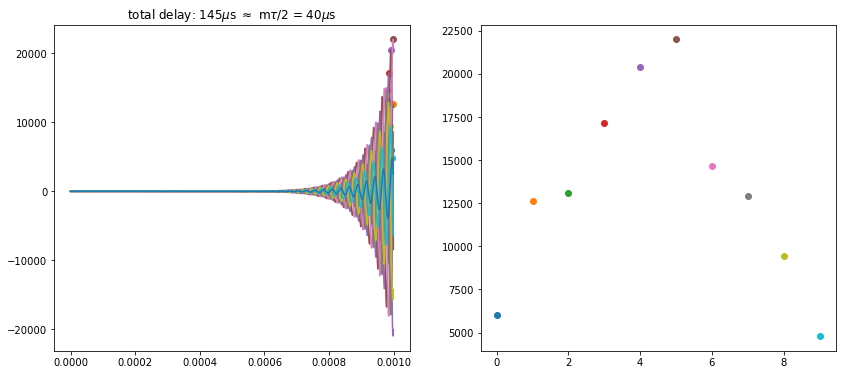

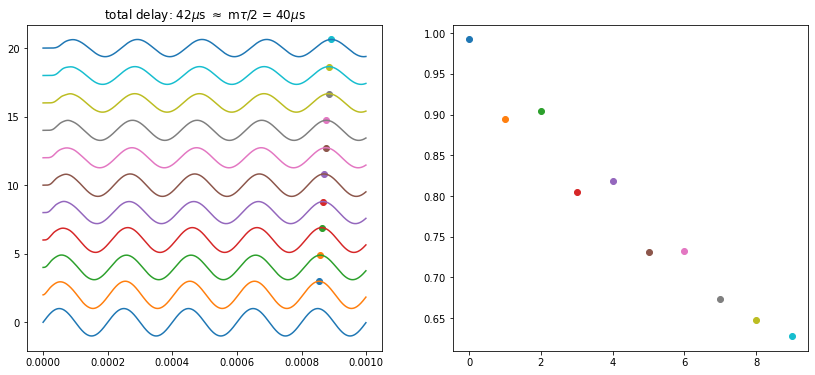

In [169]:
dt = 1e-6

t = np.arange(int(T/dt))*dt
signal = np.sin(t*2*np.pi*freq).reshape(-1, 1)

ladder = LadderEuler(tau=8e-6, m=10, a=0.1)
output = ladder.apply(signal, dt=dt)
make_delay_plot(ladder, signal, output)

ladder = LadderZOH(tau=8e-6, m=10, a=0.1)
output = ladder.apply(signal, dt=dt)
make_delay_plot(ladder, signal, output)

As hoped, the ZOH version works fine for much larger dt than the forward Euler version.